In [5]:
import pandas as pd

# Step 1: Load Dataset
file_path = 'iot_data.csv'  # Update this with the correct file path if necessary
dataset = pd.read_csv(file_path)


# Step 2: Data Cleaning
# Remove duplicates
dataset = dataset.drop_duplicates()

# Convert date column to datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# Clip any negative values in numeric columns
numeric_columns = ['daily_demand', 'stock_level', 'reorder_level', 'supplier_delay']
for col in numeric_columns:
    dataset[col] = dataset[col].clip(lower=0)

print("Data Cleaning Complete.")


Data Cleaning Complete.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


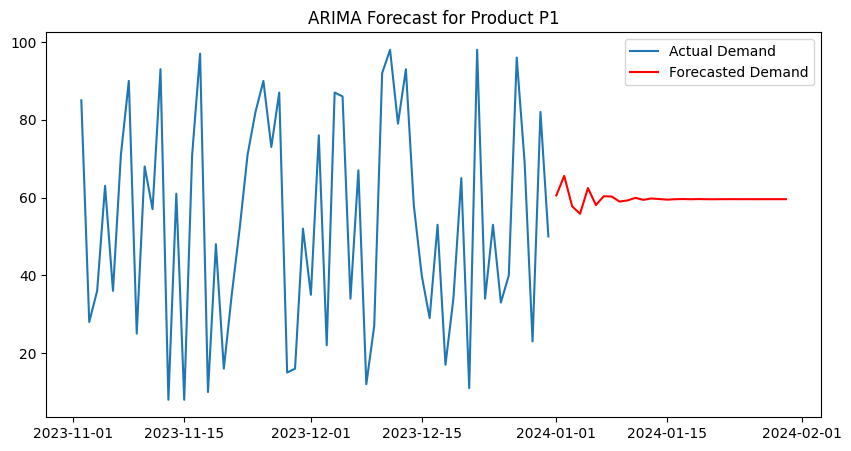

ARIMA Forecast Complete.


In [6]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Filter data for a specific product (e.g., 'P1')
product_id = "P1"
product_data = dataset[dataset["product_id"] == product_id]
demand_series = product_data.set_index("date")["daily_demand"]

# Fit ARIMA model
arima_model = ARIMA(demand_series, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast demand for the next 30 days
forecast = arima_fit.forecast(steps=30)

# Plot actual vs forecasted demand
plt.figure(figsize=(10, 5))
plt.plot(demand_series[-60:], label="Actual Demand")
plt.plot(forecast, label="Forecasted Demand", color="red")
plt.title(f"ARIMA Forecast for Product {product_id}")
plt.legend()
plt.show()

print("ARIMA Forecast Complete.")


In [7]:
# Define reorder logic
def optimize_inventory(row, forecasted_demand):
    if row["stock_level"] < row["reorder_level"]:
        reorder_quantity = sum(forecasted_demand[:30]) - row["stock_level"]
        return max(reorder_quantity, 0)  # Ensure reorder quantity is non-negative
    return 0

# Apply optimization to the product data
forecast_values = forecast.values  # Forecasted demand for the next 30 days
product_data["reorder_quantity"] = product_data.apply(
    lambda row: optimize_inventory(row, forecast_values), axis=1
)

# Display updated product data
print(product_data.tail())


            date product_id  daily_demand  stock_level  reorder_level  \
18000 2023-12-27         P1            96          164             43   
18050 2023-12-28         P1            69          228             79   
18100 2023-12-29         P1            23          126             44   
18150 2023-12-30         P1            82          264             49   
18200 2023-12-31         P1            50          484             99   

       supplier_delay  reorder_quantity  
18000               6               0.0  
18050               7               0.0  
18100               2               0.0  
18150               8               0.0  
18200               1               0.0  


<ipython-input-7-641de19cef88>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_data["reorder_quantity"] = product_data.apply(


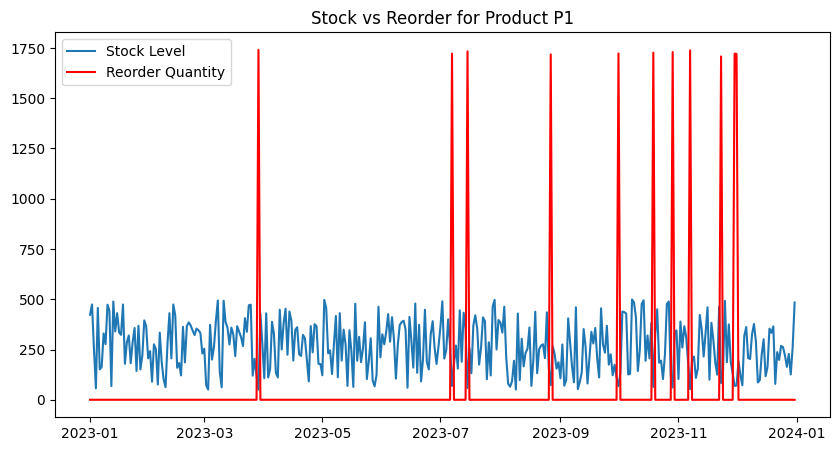

Optimized inventory saved to optimized_inventory.csv


In [8]:
# Plot stock level vs reorder quantity
plt.figure(figsize=(10, 5))
plt.plot(product_data["date"], product_data["stock_level"], label="Stock Level")
plt.plot(product_data["date"], product_data["reorder_quantity"], label="Reorder Quantity", color="red")
plt.title(f"Stock vs Reorder for Product {product_id}")
plt.legend()
plt.show()

# Save the updated product data to a CSV file
output_path = "optimized_inventory.csv"
product_data.to_csv(output_path, index=False)
print(f"Optimized inventory saved to {output_path}")
